In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import scipy.optimize as opt
import seaborn
import timeit

In [2]:
# Read the data
df = pd.read_csv("processed_NFCS.csv")
df.head(15)

ID  year   weights  state_cate  state_dummy_1  state_dummy_2  \
0   2012010001  2012  0.363417          24              0              0   
1   2012010002  2012  1.173593          10              0              0   
2   2012010003  2012  1.577671          23              0              0   
3   2012010004  2012  1.577671          14              0              0   
4   2012010005  2012  2.167569          44              0              0   
5   2012010006  2012  0.513483          25              0              0   
6   2012010007  2012  2.234989          31              0              0   
7   2012010008  2012  0.753603          22              0              0   
8   2012010009  2012  1.576065           5              0              0   
9   2012010010  2012  1.466195           4              0              0   
10  2012010011  2012  1.338353          14              0              0   
11  2012010012  2012  0.415504           7              0              0   
12  2012010013  2012  1.134205          38              0              0   
13  2012010014  2012  1.550855           5              0              0   
14  2012010015  2012  1.352778          38              0              0   

    state_dummy_3  state_dummy_4  state_dummy_5  state_dummy_6  ...  \
0               0              0              0              0  ...   
1               0              0              0              0  ...   
2               0              0              0              0  ...   
3               0              0              0              0  ...   
4               0              0              0              0  ...   
5               0              0              0              0  ...   
6               0              0              0              0  ...   
7               0              0              0              0  ...   
8               0              0              1              0  ...   
9               0              1              0              0  ...   
10              0              0              0              0  ...   
11              0              0              0              0  ...   
12              0              0              0              0  ...   
13              0              0              1              0  ...   
14              0              0              0              0  ...   

    precaution_dummy  retire_dummy  fin_par_dummy  math_perceived_cate  \
0                  0             0              1                    7   
1                  0             0              0                    6   
2                  1             0              0                    7   
3                  0             0              1                    4   
4                  1             0              0                    6   
5                  0             0              1                    1   
6                  1             1              1                    7   
7                  1             0              0                    5   
8                  1             0              0                    5   
9                  0             0              0                    2   
10                 1             0              1                    3   
11                 0             0              0                    5   
12                 0             0              0                    7   
13                 0             0              0                    6   
14                 1             1              0                    6   

    fin_perceived_cate  interest_q  inflation_q  bond_q  mortgage_q  mutual_q  
0                    6           1            1       3           1         1  
1                    5           1            2       2           2         2  
2                    5           1            1       2           1         1  
3                    4           3            2       2           2         2  
4                    6           1            3       2           1      

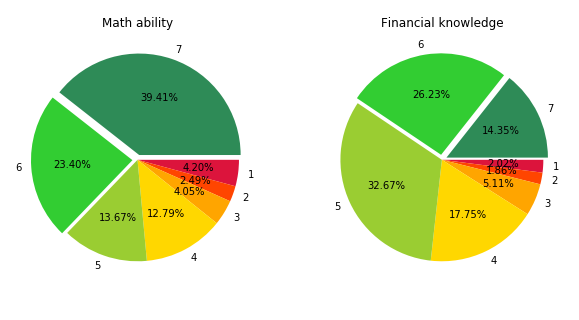

In [3]:
# Draw Pie charts for perceived financial literacy
math_perceived_data = \
    [np.dot((df['math_perceived_cate'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 8)]
fin_perceived_data = \
    [np.dot((df['fin_perceived_cate'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 8)]
perceived_label = [i for i in range(1, 8)]
perceived_explode = [0, 0, 0, 0, 0, 0.05, 0.05]
perceived_color = ['crimson', 'orangered','orange', 'gold', 'yellowgreen','limegreen', 'seagreen']

fig = plt.figure(figsize=(10, 5.5))
plt.gca().spines['right'].set_visible(None)
plt.gca().spines['left'].set_visible(None)
plt.gca().spines['top'].set_visible(None)
plt.gca().spines['bottom'].set_visible(None)
plt.xticks(())
plt.yticks(())
ax1 = fig.add_subplot(1, 2, 1)
ax1.pie(x=math_perceived_data, autopct='%.2f%%', colors=perceived_color,
        labels=perceived_label, counterclock=False, explode=perceived_explode)
ax1.set_title('Math ability', fontsize=12)
ax2 = fig.add_subplot(1, 2, 2)
ax2.pie(x=fin_perceived_data, autopct='%.2f%%', colors=perceived_color,
        labels=perceived_label, counterclock=False, explode=perceived_explode)
ax2.set_title('Financial knowledge', fontsize=12)
plt.savefig("Perceived_pie.png")
plt.show()

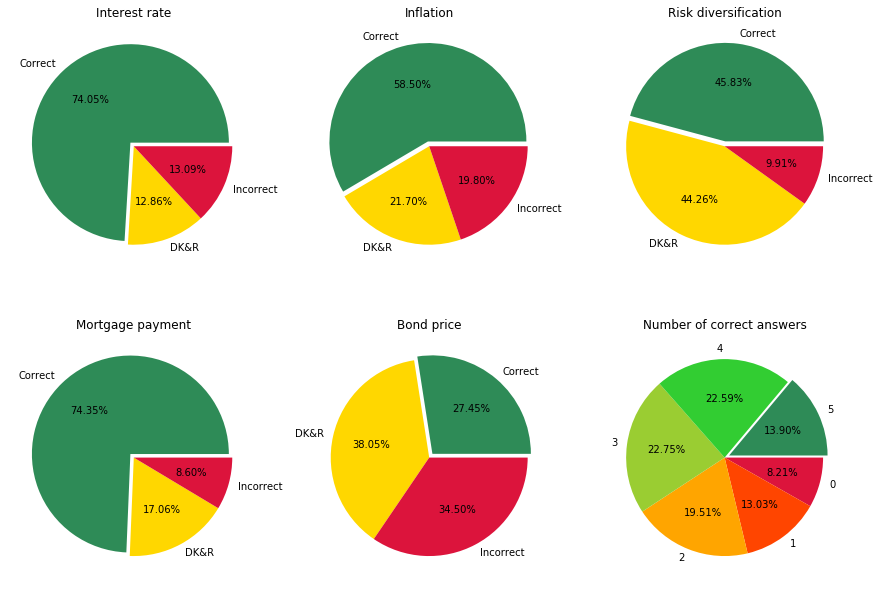

In [4]:
# Draw Pie charts for true financial literacy
interest_data = \
    [np.dot((df['interest_q'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 4)]
inflation_data = \
    [np.dot((df['inflation_q'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 4)]
mutual_data = \
    [np.dot((df['mutual_q'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 4)]
mortgage_data = \
    [np.dot((df['mortgage_q'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 4)]
bond_data = \
    [np.dot((df['bond_q'] == i).values, df.loc[:, 'weights']) / len(df) for i in range(1, 4)]
sum_data = \
    [np.dot(((df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == i).values, 
            df.loc[:, 'weights']) for i in range(6)]
true_label = ['Correct', 'DK&R', 'Incorrect']
true_explode = [0.05, 0, 0]
true_color = ['seagreen', 'gold', 'crimson']
sum_label = [i for i in range(6)]
sum_explode = [0, 0, 0, 0, 0, 0.05]
sum_color = ['crimson', 'orangered','orange', 'yellowgreen','limegreen', 'seagreen']

fig = plt.figure(figsize=(15, 10.5))
plt.gca().spines['right'].set_visible(None)
plt.gca().spines['left'].set_visible(None)
plt.gca().spines['top'].set_visible(None)
plt.gca().spines['bottom'].set_visible(None)
plt.xticks(())
plt.yticks(())
ax1 = fig.add_subplot(2, 3, 1)
ax1.pie(x=interest_data, autopct='%.2f%%', colors=true_color,
        labels=true_label, counterclock=True, explode=true_explode)
ax1.set_title('Interest rate', fontsize=12)
ax2 = fig.add_subplot(2, 3, 2)
ax2.pie(x=inflation_data, autopct='%.2f%%', colors=true_color,
        labels=true_label, counterclock=True, explode=true_explode)
ax2.set_title('Inflation', fontsize=12)
ax3 = fig.add_subplot(2, 3, 3)
ax3.pie(x=mutual_data, autopct='%.2f%%', colors=true_color,
        labels=true_label, counterclock=True, explode=true_explode)
ax3.set_title('Risk diversification', fontsize=12)
ax4 = fig.add_subplot(2, 3, 4)
ax4.pie(x=mortgage_data, autopct='%.2f%%', colors=true_color,
        labels=true_label, counterclock=True, explode=true_explode)
ax4.set_title('Mortgage payment', fontsize=12)
ax5 = fig.add_subplot(2, 3, 5)
ax5.pie(x=bond_data, autopct='%.2f%%', colors=true_color,
        labels=true_label, counterclock=True, explode=true_explode)
ax5.set_title('Bond price', fontsize=12)
ax6 = fig.add_subplot(2, 3, 6)
ax6.pie(x=sum_data, autopct='%.2f%%', colors=sum_color,
        labels=sum_label, counterclock=False, explode=sum_explode)
ax6.set_title('Number of correct answers', fontsize=12)
plt.savefig("True_pie.png")
plt.show()

In [5]:
# Generate all correct and all incorrect indicator
correct_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 5
df['q_all_correct'] = correct_indicator
incorrect_indicator = (df[['interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']] == 1).sum(axis=1) == 0
df['q_all_incorrect'] = incorrect_indicator

In [6]:
# Construct pre-trained overconfidence measure
df['overconfidence'] = np.nan
one_indicator = df['q_all_incorrect'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)
zero_indicator = ((df['q_all_incorrect'] & (df['math_perceived_cate'] < 3) & (df['fin_perceived_cate'] < 3)) | 
                  (df['q_all_correct'] & (df['math_perceived_cate'] > 5) & (df['fin_perceived_cate'] > 5)))
df.loc[one_indicator, 'overconfidence'] = 1
df.loc[zero_indicator, 'overconfidence'] = 0

In [7]:
# Construct a dataframe for machine learning
ml_df = df.loc[df['overconfidence'].notnull(), :].copy()
ml_df

ID  year   weights  state_cate  state_dummy_1  state_dummy_2  \
46     2012010047  2012  1.679737           5              0              0   
81     2012010082  2012  2.234989          31              0              0   
84     2012010085  2012  1.178272          14              0              0   
99     2012010100  2012  1.697046          50              0              0   
113    2012010114  2012  1.086083          47              0              0   
122    2012010123  2012  0.876489          41              0              0   
138    2012010139  2012  1.065287          23              0              0   
144    2012010145  2012  0.313277           3              0              0   
152    2012010153  2012  2.298142          33              0              0   
161    2012010162  2012  1.697046          15              0              0   
167    2012010168  2012  0.353431          26              0              0   
179    2012010180  2012  0.598237          18              0              0   
187    2012010188  2012  1.017990          19              0              0   
200    2012010201  2012  0.353431          26              0              0   
201    2012010202  2012  0.279850           6              0              0   
203    2012010204  2012  0.523424          28              0              0   
205    2012010206  2012  1.465200          48              0              0   
236    2012010237  2012  2.234989          31              0              0   
239    2012010240  2012  2.234989          31              0              0   
245    2012010246  2012  1.551769          33              0              0   
248    2012010249  2012  0.438809          51              0              0   
290    2012010291  2012  3.397488          39              0              0   
293    2012010294  2012  1.268877          10              0              0   
308    2012010309  2012  1.693709          33              0              0   
345    2012010346  2012  0.864927          41              0              0   
348    2012010349  2012  2.748256          33              0              0   
368    2012010369  2012  2.021372          10              0              0   
374    2012010375  2012  1.816114           5              0              0   
383    2012010384  2012  1.674660          36              0              0   
387    2012010388  2012  1.495969          14              0              0   
...           ...   ...       ...         ...            ...            ...   
79919  2018036847  2018  0.385926          51              0              0   
79928  2018036856  2018  0.396007          51              0              0   
79936  2018036864  2018  1.580155          12              0              0   
79947  2018036875  2018  1.720190          12              0              0   
79949  2018036877  2018  1.369424          12              0              0   
79955  2018036883  2018  0.440668          28              0              0   
79961  2018036889  2018  0.414749          28              0              0   
79972  2018036900  2018  1.720190          12              0              0   
79995  2018036923  2018  1.006108           8              0              0   
80005  2018036933  2018  1.720190          12              0              0   
80006  2018036934  2018  2.166118          12              0              0   
80008  2018036936  2018  1.369424          12              0              0   
80011  2018036939  2018  0.980497           8              0              0   
80012  2018036940  2018  0.372715          51              0              0   
80015  2018036943  2018  1.369424          12              0              0   
80017  2018036945  2018  1.800757          12              0              0   
80026  2018036954  2018  2.183984          12              0              0   
80030  2018036958  2018  1.661302          12              0              0   
80032  2018036960  2018  0.400652          51              0     

In [8]:
# Construct a dataframe for out-of-sample prediction
pr_df = df.loc[~df['overconfidence'].notnull(), :].copy()
pr_df

ID  year   weights  state_cate  state_dummy_1  state_dummy_2  \
0      2012010001  2012  0.363417          24              0              0   
1      2012010002  2012  1.173593          10              0              0   
2      2012010003  2012  1.577671          23              0              0   
3      2012010004  2012  1.577671          14              0              0   
4      2012010005  2012  2.167569          44              0              0   
5      2012010006  2012  0.513483          25              0              0   
6      2012010007  2012  2.234989          31              0              0   
7      2012010008  2012  0.753603          22              0              0   
8      2012010009  2012  1.576065           5              0              0   
9      2012010010  2012  1.466195           4              0              0   
10     2012010011  2012  1.338353          14              0              0   
11     2012010012  2012  0.415504           7              0              0   
12     2012010013  2012  1.134205          38              0              0   
13     2012010014  2012  1.550855           5              0              0   
14     2012010015  2012  1.352778          38              0              0   
15     2012010016  2012  1.095389          14              0              0   
16     2012010017  2012  1.095389          36              0              0   
17     2012010018  2012  0.279122          22              0              0   
18     2012010019  2012  1.679737           5              0              0   
19     2012010020  2012  1.806835          38              0              0   
20     2012010021  2012  1.595617          33              0              0   
21     2012010022  2012  0.467574          16              0              0   
22     2012010023  2012  1.173593          34              0              0   
23     2012010024  2012  0.930770          19              0              0   
24     2012010025  2012  0.313277          45              0              0   
25     2012010026  2012  1.425360          33              0              0   
26     2012010027  2012  1.065287          36              0              0   
27     2012010028  2012  0.303876          22              0              0   
28     2012010029  2012  1.534317          23              0              0   
29     2012010030  2012  0.402014           7              0              0   
...           ...   ...       ...         ...            ...            ...   
80133  2018037061  2018  0.469334          51              0              0   
80134  2018037062  2018  0.372715          51              0              0   
80135  2018037063  2018  0.507483          51              0              0   
80136  2018037064  2018  0.404002          51              0              0   
80137  2018037065  2018  0.400652          51              0              0   
80138  2018037066  2018  0.498665          51              0              0   
80139  2018037067  2018  0.469334          51              0              0   
80140  2018037068  2018  0.620629          51              0              0   
80141  2018037069  2018  0.404002          51              0              0   
80142  2018037070  2018  0.396007          51              0              0   
80143  2018037071  2018  0.469334          51              0              0   
80144  2018037072  2018  0.400652          51              0              0   
80145  2018037073  2018  0.708752          51              0              0   
80146  2018037074  2018  0.469334          51              0              0   
80148  2018037076  2018  0.564230          51              0              0   
80149  2018037077  2018  0.404002          51              0              0   
80150  2018037078  2018  0.404002          51              0              0   
80151  2018037079  2018  0.318172          51              0              0   
80152  2018037080  2018  0.498665          51              0     

### Logistic Regression

In [9]:
# Construct dependent and independent variable
state_dummy_list = ['state_dummy_{}'.format(i) for i in range(1, 52)]
X_list = state_dummy_list + ['age', 'female_dummy', 'nonwhite_dummy', 'marital_dummy', 'high_school_dummy', 
                             'college_dummy', 'graduate_dummy', 'income', 'math_perceived_cate', 
                             'fin_perceived_cate', 'interest_q', 'inflation_q', 'bond_q', 'mortgage_q', 'mutual_q']
X = ml_df[X_list]
y = ml_df['overconfidence'].astype('int')
X_pred = pr_df[X_list]

In [10]:
# Specify parameter distributions as suggested
param_dist_1 = {'C': sp_uniform(0.1, 4.0)}

overconfidence_clf_1 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=0)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_1 = RandomizedSearchCV(overconfidence_clf_1, param_distributions=param_dist_1,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_1.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_1.best_params_)
print('The MSE of the optimal results is', -random_search_1.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 0.6734131496361856}
The MSE of the optimal results is 0.06707317073170732

Total time used: 18 s


In [11]:
# Out of sample prediction
y_pred_1 = random_search_1.predict_proba(X_pred)

In [12]:
pr_df['overconfidence_logit'] = y_pred_1[:, 1]
pr_df['overconfidence_logit'].describe()

count    71800.000000
mean         0.259043
std          0.284184
min          0.000074
25%          0.029732
50%          0.122757
75%          0.447860
max          0.979811
Name: overconfidence_logit, dtype: float64

### Random Forest

In [13]:
# Specify parameter distributions as suggested
param_dist_2 = {'n_estimators': sp_randint(10, 200),
                'max_depth': sp_randint(2, 5),
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 4)}

overconfidence_clf_2 = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=0)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_2 = RandomizedSearchCV(overconfidence_clf_2, param_distributions=param_dist_2,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_2.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_2.best_params_)
print('The MSE of the optimal results is', -random_search_2.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 7, 'min_samples_split': 13, 'n_estimators': 42}
The MSE of the optimal results is 0.0027498804399808704

Total time used: 36 s


In [14]:
# Out of sample prediction
y_pred_2 = random_search_2.predict_proba(X_pred)

In [15]:
pr_df['overconfidence_forest'] = y_pred_2[:, 1]
pr_df['overconfidence_forest'].describe()

count    71800.000000
mean         0.234009
std          0.136858
min          0.012328
25%          0.122749
50%          0.207779
75%          0.329837
max          0.650067
Name: overconfidence_forest, dtype: float64

### Support Vector Machine Classifier

In [16]:
# Specify parameter distributions as suggested
param_dist_3 = {'C': sp_uniform(loc=0.1, scale=2.0)}

overconfidence_clf_3 = SVC(kernel='rbf', random_state=0, probability=True)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_3 = RandomizedSearchCV(overconfidence_clf_3, param_distributions=param_dist_3,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_3.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_3.best_params_)
print('The MSE of the optimal results is', -random_search_3.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The optimal tuning parameter values from randomized hyperparameter search are
 {'C': 2.057236684465528}
The MSE of the optimal results is 0.0009564801530368245

Total time used: 16 min 20 s


In [17]:
# Out of sample prediction
y_pred_3 = random_search_3.predict_proba(X_pred)

In [18]:
pr_df['overconfidence_svm'] = y_pred_3[:, 1]
pr_df['overconfidence_svm'].describe()

count    7.180000e+04
mean     3.952895e-01
std      4.206121e-01
min      1.000000e-07
25%      7.676603e-03
50%      1.437993e-01
75%      9.247211e-01
max      1.000000e+00
Name: overconfidence_svm, dtype: float64

### Bernoulli Naive Bayes

In [19]:
# Specify parameter distributions as suggested
param_dist_4 = {'alpha': sp_uniform(0.001, 3.0)}

overconfidence_clf_4 = BernoulliNB()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_4 = RandomizedSearchCV(overconfidence_clf_4, param_distributions=param_dist_4,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_4.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_4.best_params_)
print('The MSE of the optimal results is', -random_search_4.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 0.282821532275325}
The MSE of the optimal results is 0.10712577714012435

Total time used: 4 s


In [20]:
# Out of sample prediction
y_pred_4 = random_search_4.predict_proba(X_pred)

In [21]:
pr_df['overconfidence_bnb'] = y_pred_4[:, 1]
pr_df['overconfidence_bnb'].describe()

count    71800.000000
mean         0.217606
std          0.199168
min          0.002806
25%          0.061703
50%          0.153187
75%          0.318734
max          0.945734
Name: overconfidence_bnb, dtype: float64

### KNN Classifier

In [22]:
# Specify parameter distributions as suggested
param_dist_5 = {'n_neighbors': sp_randint(50, 500)}

overconfidence_clf_5 = KNeighborsClassifier()

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_5 = RandomizedSearchCV(overconfidence_clf_5, param_distributions=param_dist_5,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_5.fit(X, y)

running_time = timeit.default_timer() - start_time

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_5.best_params_)
print('The MSE of the optimal results is', -random_search_5.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'n_neighbors': 97}
The MSE of the optimal results is 0.07436633189861311

Total time used: 3 min 39 s


In [23]:
# Out of sample prediction
y_pred_5 = random_search_5.predict_proba(X_pred)

In [24]:
pr_df['overconfidence_knn'] = y_pred_5[:, 1]
pr_df['overconfidence_knn'].describe()

count    71800.000000
mean         0.197328
std          0.175997
min          0.000000
25%          0.030928
50%          0.154639
75%          0.340206
max          0.731959
Name: overconfidence_knn, dtype: float64

### MLP Classifier

In [25]:
# Specify parameter distributions as suggested
param_dist_6 = {'hidden_layer_sizes': [300 * i for i in range(6, 9)],
                'alpha': sp_uniform(0.001, 0.1)}

overconfidence_clf_6 = MLPClassifier(learning_rate_init=0.02, random_state=0)

# Run randomized hyperparameter search
start_time = timeit.default_timer()

random_search_6 = RandomizedSearchCV(overconfidence_clf_6, param_distributions=param_dist_6,
                                     n_iter=100, n_jobs=4, cv=5, random_state=0,
                                     scoring='neg_mean_squared_error')

random_search_6.fit(X, y)

running_time = timeit.default_timer() - start_time 

print('The optimal tuning parameter values from randomized hyperparameter search are\n',
      random_search_6.best_params_)
print('The MSE of the optimal results is', -random_search_6.best_score_)
if running_time < 60:
    print('\nTotal time used: {:.0f} s'.format(running_time))
else:
    print('\nTotal time used: {:.0f} min {:.0f} s'.format(running_time // 60, running_time % 60))

The optimal tuning parameter values from randomized hyperparameter search are
 {'alpha': 0.015644176272911224, 'hidden_layer_sizes': 2400}
The MSE of the optimal results is 0.09026781444285031

Total time used: 49 min 13 s


In [26]:
# Out of sample prediction
y_pred_6 = random_search_6.predict_proba(X_pred)

In [27]:
pr_df['overconfidence_mlp'] = y_pred_6[:, 1]
pr_df['overconfidence_mlp'].describe()

count    71800.000000
mean         0.189213
std          0.116616
min          0.006752
25%          0.098529
50%          0.174268
75%          0.268629
max          0.709106
Name: overconfidence_mlp, dtype: float64

### Compare the MSEs

In [28]:
address = '~/Overconfidence-Financial-Behaviors/'

In [29]:
# Construct a dataframe for MSEs
MSE_dict = {'method': ['Logistic', 'Forest', 'SVM', 'BNB', 'KNN', 'MLP'],
            'MSE': [-random_search_1.best_score_, -random_search_2.best_score_, 
                    -random_search_3.best_score_, -random_search_4.best_score_,
                    -random_search_5.best_score_, -random_search_6.best_score_]}

MSE_df = pd.DataFrame(MSE_dict)
MSE_df.to_csv(address + 'MSE.csv', index=False)

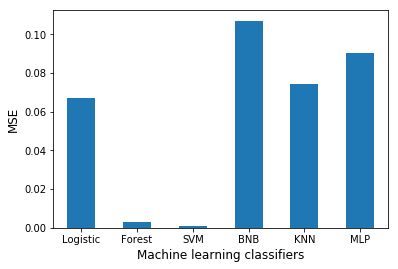

In [30]:
# Draw a bar plot to compare MSEs
ax = MSE_df.plot.bar(x='method', y='MSE', rot=0, legend=None)
ax.set_xlabel("Machine learning classifiers", fontsize=12)
ax.set_ylabel("MSE", fontsize=12)
plt.savefig("MSE.png")
plt.show()

### Confusion matrix

In [31]:
# Split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [32]:
# Logistic regression confusion matrix
overconfidence_clf_1o = LogisticRegression(C=random_search_1.best_params_['C'], 
                                           penalty='l2',
                                           solver='lbfgs',
                                           random_state=0)
overconfidence_clf_1o.fit(X_train, y_train)

predictions_logit = overconfidence_clf_1o.predict(X_test)
mat_logit = confusion_matrix(y_test, predictions_logit) / len(y_test)

In [33]:
# Random forest confusion matrix
overconfidence_clf_2o = RandomForestClassifier(bootstrap=True, 
                                               oob_score=True,
                                               n_estimators=random_search_2.best_params_['n_estimators'],
                                               max_depth=random_search_2.best_params_['max_depth'],
                                               min_samples_split=random_search_2.best_params_['min_samples_split'],
                                               min_samples_leaf=random_search_2.best_params_['min_samples_leaf'],
                                               max_features=random_search_2.best_params_['max_features'],
                                               random_state=0)
overconfidence_clf_2o.fit(X_train, y_train)

predictions_forest = overconfidence_clf_2o.predict(X_test)
mat_forest = confusion_matrix(y_test, predictions_forest) / len(y_test)

In [34]:
# SVM confusion matrix
overconfidence_clf_3o = SVC(kernel='rbf',
                            C=random_search_3.best_params_['C'],
                            probability=True)
overconfidence_clf_3o.fit(X_train, y_train)

predictions_SVM = overconfidence_clf_3o.predict(X_test)
mat_SVM = confusion_matrix(y_test, predictions_SVM) / len(y_test)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [35]:
# BNB confusion matrix
overconfidence_clf_4o = BernoulliNB(alpha=random_search_4.best_params_['alpha'])
overconfidence_clf_4o.fit(X_train, y_train)

predictions_BNB = overconfidence_clf_4o.predict(X_test)
mat_BNB = confusion_matrix(y_test, predictions_BNB) / len(y_test)

In [36]:
# KNN confusion matrix
overconfidence_clf_5o = KNeighborsClassifier(n_neighbors=random_search_5.best_params_['n_neighbors'])
overconfidence_clf_5o.fit(X, y)

predictions_KNN = overconfidence_clf_5o.predict(X_test)
mat_KNN = confusion_matrix(y_test, predictions_KNN) / len(y_test)

In [37]:
# MLP confusion matrix
overconfidence_clf_6o = MLPClassifier(alpha=random_search_6.best_params_['alpha'],
                                      hidden_layer_sizes=random_search_6.best_params_['hidden_layer_sizes'],
                                      learning_rate_init=0.02, 
                                      random_state=0)
overconfidence_clf_6o.fit(X_train, y_train)

predictions_MLP = overconfidence_clf_6o.predict(X_test)
mat_MLP = confusion_matrix(y_test, predictions_MLP) / len(y_test)

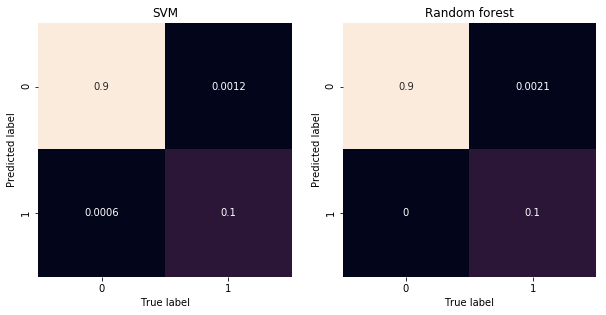

In [38]:
# Plot the matrices for SVM and random forest
fig = plt.figure(figsize=(10, 11))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = seaborn.heatmap(mat_SVM.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax1.set_title('SVM', fontsize=12)
ax1.set_xlabel('True label')
ax1.set_ylabel('Predicted label')
ax2 = fig.add_subplot(1, 2, 2)
ax2 = seaborn.heatmap(mat_forest.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax2.set_title('Random forest', fontsize=12)
ax2.set_xlabel('True label')
ax2.set_ylabel('Predicted label')
plt.savefig('confusion_matrix_main.png')
plt.show()

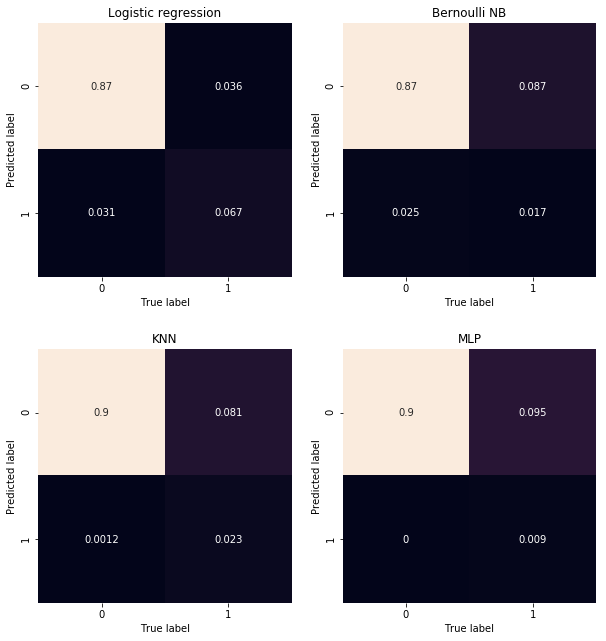

In [39]:
# Plot the matrices for other classifiers
fig = plt.figure(figsize=(10, 11))
ax1 = fig.add_subplot(2, 2, 1)
ax1 = seaborn.heatmap(mat_logit.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax1.set_title('Logistic regression', fontsize=12)
ax1.set_xlabel('True label')
ax1.set_ylabel('Predicted label')
ax2 = fig.add_subplot(2, 2, 2)
ax2 = seaborn.heatmap(mat_BNB.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax2.set_title('Bernoulli NB', fontsize=12)
ax2.set_xlabel('True label')
ax2.set_ylabel('Predicted label')
ax3 = fig.add_subplot(2, 2, 3)
ax3 = seaborn.heatmap(mat_KNN.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax3.set_title('KNN', fontsize=12)
ax3.set_xlabel('True label')
ax3.set_ylabel('Predicted label')
ax4 = fig.add_subplot(2, 2, 4)
ax4 = seaborn.heatmap(mat_MLP.T, square=True, annot=True, cbar=False, 
                      xticklabels=y_test.unique(), yticklabels=y_test.unique())
ax4.set_title('MLP', fontsize=12)
ax4.set_xlabel('True label')
ax4.set_ylabel('Predicted label')
plt.savefig("confusion_matrix_other.png")
plt.show()

### Export the dataframe

In [40]:
# Construct a new dataframe for export
full_df = ml_df.append(pr_df)
hardcode_indicator = ~full_df['overconfidence_logit'].notnull()
full_df.loc[hardcode_indicator, 'overconfidence_logit'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_forest'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_svm'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_bnb'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_knn'] = full_df.loc[hardcode_indicator, 'overconfidence']
full_df.loc[hardcode_indicator, 'overconfidence_mlp'] = full_df.loc[hardcode_indicator, 'overconfidence']

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [41]:
# Export the dataframe
full_df.to_csv(address + 'overconfidence_measure.csv', index=False)

In [42]:
# An unsuccessful trial: use PCA to visualize overconfidence
# pca = PCA(n_components=2, svd_solver='arpack', random_state=0)
# reduced_features = pca.fit_transform(ml_df[X_list].values)
# transformed_df = pd.DataFrame({'vect': [r for r in reduced_features], 'overconfidence': ml_df['overconfidence']})

# catsMap = {c: i for i, c in enumerate(np.unique(ml_df['overconfidence']))}
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.axis('off')
# pallet = seaborn.color_palette(palette='coolwarm', n_colors=2)

# xx, yy = np.meshgrid(np.arange(1.1 * reduced_features[:, 0].min(), 1.1 * reduced_features[:, 0].max(), 100), 
#                      np.arange(1.1 * reduced_features[:, 1].min(), 1.1 * reduced_features[:, 1].max(), 0.01))

# Z = random_search_2.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
# Z = np.vectorize(lambda x: catsMap[x])(Z)
# Z = Z.reshape(xx.shape)

# plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# for i, cat in enumerate(set(ml_df['overconfidence'])):
#     a = np.stack(transformed_df[transformed_df['overconfidence'] == cat]['vect'])
#     ax.scatter(a[:, 0], a[:, 1], c=pallet[catsMap[cat]], label=cat)
# ax.legend(loc='center right', title='overconfidence')
# plt.show()